In [3]:
import os
import pyspark
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase'
# , '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/19 21:47:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/poojaakki/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
import pandas as pd
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType

schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])

df0 = pd.read_csv('/Users/poojaakki/Desktop/projects/Fake-News-Detection-Data-Analysis/datasets/Kaggle/fake.csv')
df1 = pd.read_csv('/Users/poojaakki/Desktop/projects/Fake-News-Detection-Data-Analysis/datasets/Kaggle/true.csv')
df_fake = spark.createDataFrame(df0,schema=schema)
df_true = spark.createDataFrame(df1,schema=schema)

In [5]:
# df_fake.show(20)

In [6]:
# df_true.show(20)

In [7]:
# add a label to the data for fake news as 0 and true news as 1 and shuffle using rand
from pyspark.sql.functions import lit, rand

df= df_true.withColumn('flag', lit(1)).union(df_fake.withColumn('flag', lit(0))).orderBy(rand())

In [8]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)



<AxesSubplot:xlabel='date'>

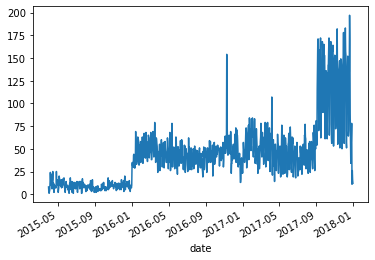

In [161]:
# number of fake and true news spread based on date
import calendar
from pyspark.sql.functions import col,to_timestamp, to_date, when, date_format
from calendar import month_abbr

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'Decenmber':12 }

df_pandas = df.toPandas()
df_pandas['date'] = df_pandas.date.str.replace(',',"")

monthDict = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 
            'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

from datetime import datetime

def check_date(x):
    correctDate = None
    try:
        correctDate=datetime.strptime(x, "%m-%d-%Y") 
    except ValueError:
        correctDate = None
    return correctDate


def convert(x):
    x[0] = x[0].capitalize()
    x[0] = x[0][0:3]
    if x[0] in monthDict.keys():
        x[0] = monthDict[x[0]]
    return x

# df_pandas.select(col("date"),col("flag")).when(to_date(col("Date"),"yyyy MMMM dd").isNotNull,date_format(to_date(col("Date"),"MMMM dd, yyyy"),"MM/dd/yyyy"))
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.rstrip())
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.split(' '))
df_pandas['date'] = df_pandas['date'].map(lambda x: convert(x))
df_pandas['date'] = df_pandas['date'].agg(lambda x: '-'.join(map(str, x)))
df_pandas['date'] = df_pandas['date'].map(lambda x:check_date(x))
df_pandas.groupby(df_pandas.date)['text'].count().plot(kind="line")


In [56]:
#types of news and highest number of news in order fromt he dataset
from pyspark.sql.functions import col

df.groupby('subject').count().sort(col("count").desc())

22/12/20 00:11:25 WARN TaskSetManager: Stage 51 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 00:11:26 WARN TaskSetManager: Stage 54 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


22/12/19 21:34:33 WARN TaskSetManager: Stage 34 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/19 21:34:34 WARN TaskSetManager: Stage 35 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:title={'center':'Points Scored by Team'}, ylabel='title'>

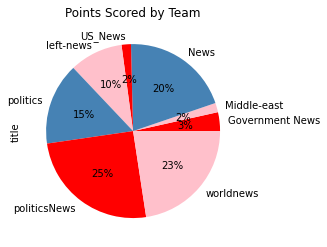

In [27]:
# Pie chart with counts of various news subjects Political and world news contained the highest counts .
from matplotlib import pyplot as plt

df1 = df

df1 = df1.toPandas()

colors = ['pink', 'silver', 'steelblue']

df1.groupby(['subject'])['title'].count().plot(kind='pie', y='count', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Points Scored by Team')

# most subject which have fake news
# most artciles which are true news

In [28]:
# type of article which have fake news

df1_fake = df_fake

df1_fake.groupby(['subject']).count()

22/12/19 21:34:35 WARN TaskSetManager: Stage 38 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.
22/12/19 21:34:35 WARN TaskSetManager: Stage 41 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


subject,count
News,9050
politics,6841
Government News,1570
left-news,4459
US_News,783
Middle-east,778


In [29]:
# type of article which have true news

df1_true = df_true

df1_true.groupby(['subject']).count()

22/12/19 21:34:35 WARN TaskSetManager: Stage 44 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/19 21:34:35 WARN TaskSetManager: Stage 47 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145


In [30]:
# text pre-processing

from pyspark.sql.functions import col, split, lower, regexp_replace, length

df = df.select('title',(lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')), 'subject', 'date', 'flag')

In [31]:
# tokenize the text

from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='text', outputCol='words_token')

df = tokenizer.transform(df).select('title','words_token','subject','date','flag')

In [32]:
# df.first()

In [33]:
# remove the stop words

# tokens=['paris', 'reuters', '', 'plans', 'to', 'buy', 'a', 'new', 'presidential', 'jet', 'for', 'france', 's', 'emmanuel', 'macron', 'could', 'be']

# clean_tokens = [ tok for tok in tokens if tok ]

# clean_tokens

In [34]:
#remove empty string from the frame
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType

def space_removal(f):
    clean_tokens = []
    for tok in f:
        if tok:
            clean_tokens.append(tok)
    return clean_tokens

udf_space_removal = udf(space_removal, ArrayType(StringType()))

df = df.withColumn('words_token', udf_space_removal(f.col('words_token')))

In [35]:
# df.first()

In [36]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/poojaakki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# remove the stop words
from pyspark.ml.feature import StopWordsRemover

stop_words_remover = StopWordsRemover(inputCol='words_token', outputCol='text').setStopWords(stop)

In [38]:
from pyspark.ml import Pipeline

stopWordRemovalPipeline = Pipeline(stages=[stop_words_remover])
pipelineFitRemoveStopWords = stopWordRemovalPipeline.fit(df)

In [39]:
df = pipelineFitRemoveStopWords.transform(df) #added here

In [40]:
# df.first()

In [41]:
# stematizing the words
# from nltk.stem.snowball import SnowballStemmer

# stemmer = SnowballStemmer(language='english')
# stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))

# df = df.withColumn("words_stemmed", stemmer_udf("text")).select('title','words_token','subject','date','flag','words_stemmed')

In [42]:
# df.first()

In [43]:
# df = df.withColumnRenamed("words_stemmed","text")

In [44]:
# df

In [45]:
# most freq words in data

from pyspark.sql.functions import concat_ws

df_freq = df.withColumn("text", concat_ws(" ", df["text"]))

# df_freq.show(5)

In [46]:
# most frequent fake words

df_fake_freq = df_freq.filter(df["flag"] == 0)

df_fake_text = df_fake_freq.select("text")


In [47]:
from pyspark.sql.functions import explode

df_fake_text = df_fake_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_fake = df_fake_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_fake.orderBy(col("count").desc()).show()

22/12/19 21:35:01 WARN TaskSetManager: Stage 50 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/19 21:35:05 WARN TaskSetManager: Stage 51 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----+
|     word|count|
+---------+-----+
|    trump|73933|
|     said|31013|
|   people|25963|
|president|25586|
|    would|23427|
|      one|22935|
|       us|22049|
|  clinton|18011|
|    obama|17813|
|     like|17621|
|   donald|17215|
|     also|15242|
|      new|14158|
|     news|14126|
|     even|13717|
|  hillary|13565|
|    white|12778|
|     time|12728|
|    state|12525|
|      via|11273|
+---------+-----+
only showing top 20 rows



In [48]:
#graph representtion of most frequent words in fake news
import seaborn as sns 

df_graph_fake = df_freq_fake.orderBy(col("count").desc())

df_graph_fake = df_graph_fake.toPandas()

ax = sns.barplot(data = df_frequency, x = "word", y = "count", color = 'blue')
ax.set(ylabel = "count")
plt.xticks(rotation='vertical')
plt.show()

22/12/19 21:36:20 WARN TaskSetManager: Stage 57 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/19 21:36:23 WARN TaskSetManager: Stage 58 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:>

Error in callback <function flush_figures at 0x7fd689d284c0> (for post_execute):


KeyboardInterrupt: 

In [124]:
#most true words

df_true_freq = df_freq.filter(df["flag"] == 1)

df_true_text = df_true_freq.select("text")

In [125]:
from pyspark.sql.functions import explode

df_true_text = df_true_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_true = df_true_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_true.orderBy(col("count").desc()).show()

22/12/04 23:09:54 WARN TaskSetManager: Stage 70 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/04 23:10:06 WARN TaskSetManager: Stage 71 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|      word|count|
+----------+-----+
|      said|98985|
|     trump|54341|
|        us|41137|
|     state|36638|
|     would|31514|
|    presid|28367|
|    reuter|28306|
|republican|22108|
|    govern|20215|
|      year|19294|
|      hous|17525|
|       new|16786|
|      unit|16525|
|  democrat|16214|
|      also|15944|
|       say|15942|
|     senat|15705|
|     elect|15524|
|     peopl|15322|
|     parti|15002|
+----------+-----+
only showing top 20 rows



In [76]:
df_freq.printSchema()

root
 |-- title: string (nullable = true)
 |-- words_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [125]:
df_freq.count()

22/12/04 22:10:01 WARN TaskSetManager: Stage 126 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


44898

In [61]:
# drop unwanted coloumns

df_ml = df_freq.drop("title","words_token","date")
df_ml.printSchema()

root
 |-- subject: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [62]:
from pyspark.sql.functions import monotonically_increasing_id 

df_ml = df_ml.select("*").withColumn("id", monotonically_increasing_id())

df_ml.show(200)

22/12/04 23:38:20 WARN TaskSetManager: Stage 34 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/04 23:38:20 WARN TaskSetManager: Stage 35 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
+---------------+----+--------------------+---+
|        subject|flag|                text| id|
+---------------+----+--------------------+---+
|           News|   0|using pimp pedoph...|  0|
|           News|   0|donald trump appe...|  1|
|   politicsNews|   1|mexico city reute...|  2|
|           News|   0|debate french tel...|  3|
|           News|   0|injured killed te...|  4|
|      worldnews|   1|johannesburg reut...|  5|
|           News|   0|trump presidentia...|  6|
|       politics|   0|one thing preside...|  7|
|   politicsNews|   1|vatican city reut...|  8|
|   politicsNews|   1|charleston sc reu...|  9|
|      worldnews|   1|townsville austra...| 10|
|        US_News|   0|us army stryker a...| 

In [63]:
# x values and Y values

x = df_ml.select('text').rdd.flatMap(lambda x: x).collect()
y = df_ml.select('flag').rdd.flatMap(lambda x: x).collect()

22/12/04 23:38:35 WARN TaskSetManager: Stage 38 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/04 23:38:35 WARN TaskSetManager: Stage 39 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/04 23:38:38 WARN TaskSetManager: Stage 42 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/04 23:38:38 WARN TaskSetManager: Stage 43 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25)

In [65]:
# print(x_train[0])
# print(y_train[0])

In [66]:
#vectorize the text

from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [68]:
xv_train

<33673x184287 sparse matrix of type '<class 'numpy.float64'>'
	with 5459366 stored elements in Compressed Sparse Row format>

In [69]:
xv_train.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
LR = LogisticRegression()
LR.fit(xv_train, y_train)

LogisticRegression()

In [72]:
LR.score(xv_test, y_test)

0.9867260579064588

In [73]:
pred_LR = LR.predict(xv_test)

In [74]:
print(classification_report(y_test, pred_LR))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5827
           1       0.98      0.99      0.99      5398

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [75]:
import re, string
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [76]:
import pandas as pd
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    print("*****")
    #print(pred_LR[0])
    print(new_xv_test)
    print(type(pred_LR[0]))
    # pred_DT = DT.predict(new_xv_test)
    # pred_GBC = GBC.predict(new_xv_test)
    # pred_RFC = RFC.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \n".format(output_lable(pred_LR[0])))

In [78]:
news = str(input())
manual_testing(news)

 Robert Fantina CounterpunchAlthough the United States is still ten months from its next exercise in electoral futility, most polls do not indicate what former Secretary of State Hillary Clinton is most anxious to see: a runaway victory for her candidacy. It is a good sign that, despite the fact that she has no real contrasting opponent on the Democratic side, the coronation she expected isn t going to happen.One might say that this writer focuses too much on Mrs. Clinton s adoration of Israel. But by looking at her comments about that apartheid nation, one gets a clear view of some broader, very troubling perspectives that Mrs. Clinton seems to hold.On January 6, an opinion piece appeared in The Jewish Journal, written by Mrs. Clinton. It is a fawning, maudlin essay, typical of the writing of anyone seeking national political office in the U.S. who knows they must pay homage to their Israeli lord and master. A few points from this essay tell much about Mrs. Clinton. I m especially con

*****
  (0, 183171)	0.02492275694953162
  (0, 182479)	0.015578230609664984
  (0, 182343)	0.01545446597732421
  (0, 181532)	0.025827828578873717
  (0, 181519)	0.02978882989741638
  (0, 181505)	0.03228833452141541
  (0, 181464)	0.0721907324777614
  (0, 180939)	0.018182332893646916
  (0, 180720)	0.018354095948939286
  (0, 179983)	0.043769314830843405
  (0, 179839)	0.02776839266809312
  (0, 178740)	0.05702995202304554
  (0, 178410)	0.026546775582323323
  (0, 177295)	0.03921346249904525
  (0, 177041)	0.07014063878922937
  (0, 176153)	0.04497694198938487
  (0, 174666)	0.047465653170058936
  (0, 174384)	0.02644329639389534
  (0, 174133)	0.026586013199937517
  (0, 174023)	0.04177701612702863
  (0, 173537)	0.03314940850477694
  (0, 173154)	0.04083120595006233
  (0, 172402)	0.033772637884687026
  (0, 171342)	0.024703627730761128
  (0, 171311)	0.03333386608908943
  :	:
  (0, 20890)	0.034989143927649284
  (0, 20550)	0.033536627079374104
  (0, 19519)	0.0370653416564245
  (0, 19077)	0.12289533916744